# Data Science Essentials - Final Project - Group 3
- Topic: Bangkok Air Pollution
- Authors:
    - Student ID: 6736748 (Liam)
    - Student ID: 6638009(Nusrat)
- Data Sources: AQI Data, WAQI Data, Open-meteo Weather Data
- Stakeholders: Pollution Control Department (PCD), Bangkok Metropolitan Administration (BMA), Thai Meteorological Department

![Bangkok Air Pollution](https://www.chinadailyhk.com/upload/main/image/2025/01/21/cc628b8ad15f9711b44cb331eb496c8c.png)

# Table of Content:
1. Define the Problem and Objectives
2. Data Collection and Acquisition
3. Data Cleaning and Preparation
4. Exploratory Data Analysis (EDA)
    - Descriptive Statistics
    - Data Visualization
5. Feature Engineering and Selection
6. Hypothesis Test
    - One-tailed t-test
    - Mann Whitney Test
7. Machine Learning / Data Modeling

# 1. Define the Problem and Objectives

## Problem Statement: 
Investigate the impact of meteorological conditions (low wind speed, high humidity, and rainfall) on PM2.5 levels in Bangkok to identify high-risk air quality scenarios and inform policy and mitigation strategies.


## Objectives:
- Test Hypothesis 1: Test if PM2.5 levels are significantly higher (>100 µg/m³) on days with low wind speed (<64 km/s) and high humidity (>70%) compared to other days.
- Test Hypothesis 2: Test if there is a significant difference in PM2.5 levels on rainy days in Bangkok compared to non-rainy days.

## Success Metrics:
- Statistical significance (p-value < 0.05) for hypothesis tests.
- Practical significance (e.g., PM2.5 exceeding 100 µg/m³ for Hypothesis 1, meaningful PM2.5 difference for Hypothesis 2).

## Stakeholder Needs:
- Pollution Control Department (PCD): Evidence-based insights to issue air quality alerts and implement emission controls.
- Bangkok Metropolitan Administration (BMA): Data to support urban planning (e.g., green spaces, traffic management) and public health measures.
- Thai Meteorological Department: Validation of weather data accuracy and insights into weather-pollution interactions to enhance forecasting.

## Constraints:
- Availability and alignment of AQI/WAQI, and Open-Meteo data.
- Potential discrepancies in weather data requiring validation.
- Need for clear, actionable outputs for non-technical stakeholders.

# 2. Data Collection and Acquisition

## Importing Libraries

In [100]:
%pip install openmeteo-requests requests-cache retry-requests numpy pandas seaborn matplotlib scipy
%pip install -U scikit-learn
import subprocess
import sys
import json
import openmeteo_requests
import requests_cache

from retry_requests import retry
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy.stats import shapiro, mannwhitneyu

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Check Air Pollution Data

This is already collected in csv format

In [101]:
# Check our daily Air Pollution CSV data
df = pd.read_csv("air_data.csv", converters={'JSON': eval}) #Evaluating json column
# view
display(df)

,Timestamp,City,AQI,PM2.5,JSON
0,2025-03-01 12:15:43,Bangkok,86,86,"{'aqi': 86, 'idx': 5773, 'attributions': [{'ur..."
1,2025-03-01 12:15:43,Beijing,261,261,"{'aqi': 261, 'idx': 1451, 'attributions': [{'u..."
2,2025-03-01 12:15:44,Los Angeles,28,28,"{'aqi': 28, 'idx': 243, 'attributions': [{'url..."
3,2025-03-02 04:49:40,Bangkok,78,78,"{'aqi': 78, 'idx': 5773, 'attributions': [{'ur..."
4,2025-03-02 04:49:40,Beijing,74,74,"{'aqi': 74, 'idx': 1451, 'attributions': [{'ur..."
...,...,...,...,...,...
148,2025-04-19 01:47:45,Beijing,97,97,"{'aqi': 97, 'idx': 1451, 'attributions': [{'ur..."
149,2025-04-19 01:47:46,Los Angeles,34,17,"{'aqi': 34, 'idx': 243, 'attributions': [{'url..."
150,2025-04-20 01:58:55,Bangkok,48,48,"{'aqi': 48, 'idx': 5773, 'attributions': [{'ur..."
151,2025-04-20 01:58:55,Beijing,160,160,"{'aqi': 160, 'idx': 1451, 'attributions': [{'u..."


## Check Open-Meteo Weather Data
Ref: https://open-meteo.com/en/docs?latitude=13.754&longitude=100.5014

In [102]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 13.754,
	"longitude": 100.5014,
	"daily": [
		"apparent_temperature_mean",
		"cloud_cover_mean",
		"precipitation_sum",
		"precipitation_probability_mean",
		"pressure_msl_mean",
		"rain_sum",
		"relative_humidity_2m_mean",
		"showers_sum",
		"surface_pressure_mean",
		"temperature_2m_mean",
		"visibility_mean",
		"wind_speed_10m_mean"
	],
	"hourly": [
		"apparent_temperature",
		"cloud_cover",
		"is_day",
		"precipitation",
		"precipitation_probability",
		"pressure_msl",
		"rain",
		"relative_humidity_2m",
		"showers",
		"surface_pressure",
		"temperature_2m",
		"visibility",
		"wind_speed_10m"
	],
	"timezone": "auto",
	"start_date": "2025-03-01",
	"end_date": str(date.today()),
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data.
hourly = response.Hourly()
hourly_apparent_temperature = hourly.Variables(0).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
hourly_is_day = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()	
hourly_precipitation_probability = hourly.Variables(4).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(5).ValuesAsNumpy()
hourly_rain = hourly.Variables(6).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(7).ValuesAsNumpy()
hourly_showers = hourly.Variables(8).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(9).ValuesAsNumpy()
hourly_temperature_2m = hourly.Variables(10).ValuesAsNumpy()
hourly_visibility = hourly.Variables(11).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(12).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["Hourly apparent_temperature"] = hourly_apparent_temperature
hourly_data["Hourly cloud_cover"] = hourly_cloud_cover
hourly_data["Hourly is_day"] = hourly_is_day
hourly_data["Hourly precipitation"] = hourly_precipitation
hourly_data["Hourly precipitation_probability"] = hourly_precipitation_probability
hourly_data["Hourly pressure_msl"] = hourly_pressure_msl
hourly_data["Hourly rain"] = hourly_rain
hourly_data["Hourly relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["Hourly showers"] = hourly_showers
hourly_data["Hourly surface_pressure"] = hourly_surface_pressure
hourly_data["Hourly temperature_2m"] = hourly_temperature_2m
hourly_data["Hourly visibility"] = hourly_visibility
hourly_data["Hourly wind_speed_10m"] = hourly_wind_speed_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
display(hourly_dataframe)

# Process daily data.
daily = response.Daily()
daily_apparent_temperature_mean = daily.Variables(0).ValuesAsNumpy()
daily_cloud_cover_mean = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()
daily_precipitation_probability_mean = daily.Variables(3).ValuesAsNumpy()
daily_pressure_msl_mean = daily.Variables(4).ValuesAsNumpy()
daily_rain_sum = daily.Variables(5).ValuesAsNumpy()
daily_relative_humidity_2m_mean = daily.Variables(6).ValuesAsNumpy()
daily_showers_sum = daily.Variables(7).ValuesAsNumpy()
daily_surface_pressure_mean = daily.Variables(8).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(9).ValuesAsNumpy()
daily_visibility_mean = daily.Variables(10).ValuesAsNumpy()
daily_wind_speed_10m_mean = daily.Variables(11).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["Daily apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["Daily cloud_cover_mean"] = daily_cloud_cover_mean
daily_data["Daily precipitation_sum"] = daily_precipitation_sum
daily_data["Daily precipitation_probability_mean"] = daily_precipitation_probability_mean
daily_data["Daily pressure_msl_mean"] = daily_pressure_msl_mean
daily_data["Daily rain_sum"] = daily_rain_sum
daily_data["Daily relative_humidity_2m_mean"] = daily_relative_humidity_2m_mean
daily_data["Daily showers_sum"] = daily_showers_sum
daily_data["Daily surface_pressure_mean"] = daily_surface_pressure_mean
daily_data["Daily temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["Daily visibility_mean"] = daily_visibility_mean
daily_data["Daily wind_speed_10m_mean"] = daily_wind_speed_10m_mean

daily_dataframe = pd.DataFrame(data = daily_data)
display(daily_dataframe)

Coordinates 13.75°N 100.5°E
Elevation 7.0 m asl
Timezone b'Asia/Bangkok'b'GMT+7'
Timezone difference to GMT+0 25200 s


,date,Hourly apparent_temperature,Hourly cloud_cover,Hourly is_day,Hourly precipitation,Hourly precipitation_probability,Hourly pressure_msl,Hourly rain,Hourly relative_humidity_2m,Hourly showers,Hourly surface_pressure,Hourly temperature_2m,Hourly visibility,Hourly wind_speed_10m
0,2025-02-28 17:00:00+00:00,33.822750,34.0,0.0,0.0,0.0,1011.599976,0.0,87.0,0.0,1010.796265,27.717501,24140.0,5.937272
1,2025-02-28 18:00:00+00:00,33.643318,40.0,0.0,0.0,3.0,1011.299988,0.0,87.0,0.0,1010.496155,27.617500,24140.0,6.034700
2,2025-02-28 19:00:00+00:00,33.466030,44.0,0.0,0.0,0.0,1010.700012,0.0,88.0,0.0,1009.896423,27.417501,24140.0,5.860375
3,2025-02-28 20:00:00+00:00,33.357319,52.0,0.0,0.0,0.0,1010.200012,0.0,89.0,0.0,1009.396118,27.267500,24140.0,5.771239
4,2025-02-28 21:00:00+00:00,33.181763,69.0,0.0,0.0,0.0,1010.200012,0.0,90.0,0.0,1009.395874,27.117500,24140.0,6.130579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,2025-04-20 12:00:00+00:00,35.989059,0.0,0.0,0.0,0.0,1007.599976,0.0,69.0,0.0,1006.807617,30.817501,24140.0,8.350138
1220,2025-04-20 13:00:00+00:00,35.752453,0.0,0.0,0.0,0.0,1008.400024,0.0,74.0,0.0,1007.605469,30.167501,24140.0,7.952660
1221,2025-04-20 14:00:00+00:00,35.729538,0.0,0.0,0.0,0.0,1009.400024,0.0,77.0,0.0,1008.603699,29.817501,24140.0,7.208994
1222,2025-04-20 15:00:00+00:00,35.647789,13.0,0.0,0.0,0.0,1010.099976,0.0,78.0,0.0,1009.302856,29.717501,24140.0,7.636753


,date,Daily apparent_temperature_mean,Daily cloud_cover_mean,Daily precipitation_sum,Daily precipitation_probability_mean,Daily pressure_msl_mean,Daily rain_sum,Daily relative_humidity_2m_mean,Daily showers_sum,Daily surface_pressure_mean,Daily temperature_2m_mean,Daily visibility_mean,Daily wind_speed_10m_mean
0,2025-02-28 17:00:00+00:00,34.930786,51.125000,0.000000,3.375000,1010.174866,0.0,78.125000,0.000000,1009.376221,29.190420,24140.000000,8.007938
1,2025-03-01 17:00:00+00:00,34.955303,36.750000,0.000000,0.000000,1008.516602,0.0,76.166664,0.000000,1007.719727,29.325836,24140.000000,7.968113
2,2025-03-02 17:00:00+00:00,35.175392,37.916668,0.000000,1.958333,1008.320862,0.0,75.958336,0.000000,1007.524719,29.582079,24140.000000,8.818902
3,2025-03-03 17:00:00+00:00,34.495472,32.291668,0.000000,0.250000,1008.062439,0.0,74.333336,0.000000,1007.266113,29.359167,24140.000000,9.749820
4,2025-03-04 17:00:00+00:00,34.908817,34.375000,0.000000,0.000000,1007.558167,0.0,74.583336,0.000000,1006.762451,29.488337,24140.000000,8.836523
5,2025-03-05 17:00:00+00:00,35.011391,28.416666,0.000000,0.333333,1008.612488,0.0,75.458336,0.000000,1007.815735,29.438334,24140.000000,8.449785
6,2025-03-06 17:00:00+00:00,34.475636,74.958336,1.800000,20.250000,1009.204102,0.0,78.000000,1.800000,1008.405518,28.932081,23837.500000,7.410603
7,2025-03-07 17:00:00+00:00,31.068680,83.208336,5.500000,14.041667,1011.083313,0.0,77.000000,5.500000,1010.277893,26.969584,20507.500000,7.471170
8,2025-03-08 17:00:00+00:00,32.929451,75.833336,0.000000,0.250000,1012.058289,0.0,67.125000,0.000000,1011.256775,28.682081,24140.000000,4.566617
9,2025-03-09 17:00:00+00:00,35.171741,40.541668,0.000000,0.000000,1011.624939,0.0,64.958336,0.000000,1010.828186,30.367500,24140.000000,4.744283


# 3. Data Cleaning and Preparation

## Extracting Data from JSON COlumn

In [103]:
def extract_aqi_features(df, json_col='JSON'):
    """
    Extracts structured air quality and weather data from a parsed JSON column into flat DataFrame columns.
    
    Args:
        df (pd.DataFrame): DataFrame with a column containing parsed JSON dictionaries.
        json_col (str): Name of the column with JSON data (default is 'JSON').
    
    Returns:
        pd.DataFrame: Original DataFrame with new extracted columns.
    """
    
    def extract_value(x, path, default=None):
        """Safely extract a nested value using a path list."""
        try:
            for p in path:
                if isinstance(p, int):  # For list indexing
                    x = x[p]
                else:
                    x = x.get(p, default)
            return x
        except Exception:
            return default

    def extract_forecast_value(x, pollutant, date):
        """Extract forecast daily average for a specific pollutant and date."""
        try:
            forecast_list = x.get('forecast', {}).get('daily', {}).get(pollutant, [])
            for entry in forecast_list:
                if entry.get('day') == date:
                    return entry.get('avg')
        except Exception:
            return None

    # Extract common air quality fields
    df['dominant_pollutant'] = df[json_col].apply(lambda x: x.get('dominentpol'))
    
    pollutants = ['pm25', 'pm10', 'co', 'no2', 'so2', 'o3']
    for pol in pollutants:
        df[pol] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', pol, 'v']))

    # Weather fields
    df['temperature'] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', 't', 'v']))
    df['humidity'] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', 'h', 'v']))
    df['wind_speed'] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', 'w', 'v']))
    df['pressure'] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', 'p', 'v']))
    df['rain'] = df[json_col].apply(lambda x: extract_value(x, ['iaqi', 'r', 'v']))

    # City and location
    df['city_geo_lat'] = df[json_col].apply(lambda x: extract_value(x, ['city', 'geo', 0]))
    df['city_geo_lon'] = df[json_col].apply(lambda x: extract_value(x, ['city', 'geo', 1]))
    # df['city_url'] = df[json_col].apply(lambda x: extract_value(x, ['city', 'url']))
    
    # Time
    # df['aqi_time_iso'] = df[json_col].apply(lambda x: extract_value(x, ['time', 'iso']))
    # df['aqi_time_local'] = df[json_col].apply(lambda x: extract_value(x, ['time', 's']))
    # df['time_zone'] = df[json_col].apply(lambda x: extract_value(x, ['time', 'tz']))

    # Forecast (match the forecast to the date in the row's Timestamp)
    # df['forecast_date'] = pd.to_datetime(df['Timestamp']).dt.strftime('%Y-%m-%d')

    # for pol in ['pm25', 'pm10', 'o3', 'uvi']:
    #     col_name = f'forecast_{pol}_avg'
    #     df[col_name] = df.apply(lambda row: extract_forecast_value(row[json_col], pol, row['forecast_date']), axis=1)

    return df

## Converting Data

In [104]:
# call function on a new df
df2 = extract_aqi_features(df)
df2["Timestamp"] = pd.to_datetime(df2["Timestamp"], utc = True)
# round to nearest hour
df2["Timestamp"] = df2["Timestamp"].dt.round("H")
# drop the original JSON column
df2.drop(columns=['JSON'], inplace=True)
# view
display(df2)

/tmp/ipykernel_1769/1518359444.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2["Timestamp"] = df2["Timestamp"].dt.round("H")


,Timestamp,City,AQI,PM2.5,dominant_pollutant,pm25,pm10,co,no2,so2,o3,temperature,humidity,wind_speed,pressure,rain,city_geo_lat,city_geo_lon
0,2025-03-01 12:00:00+00:00,Bangkok,86,86,pm25,86,50,0.1,0.6,0.6,20.5,36.4,60.0,2.0,1008.1,3.3,13.756331,100.501765
1,2025-03-01 12:00:00+00:00,Beijing,261,261,pm25,261,156,16.3,22.4,4.1,40.3,11.0,62.0,2.5,1014.0,NaN,39.954592,116.468117
2,2025-03-01 12:00:00+00:00,Los Angeles,28,28,pm25,28,11,2.3,5.0,0.2,27.2,12.2,88.0,0.1,1034.0,NaN,34.066530,-118.226760
3,2025-03-02 05:00:00+00:00,Bangkok,78,78,pm25,78,53,0.1,1.2,0.6,13.4,31.1,73.0,3.0,1009.7,3.3,13.756331,100.501765
4,2025-03-02 05:00:00+00:00,Beijing,74,74,pm25,74,41,4.6,6.4,3.6,37.0,8.0,26.0,2.5,1026.0,NaN,39.954592,116.468117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2025-04-19 02:00:00+00:00,Beijing,97,97,pm25,97,37,9.1,5.5,3.1,19.9,14.0,71.0,1.5,1011.0,NaN,39.954592,116.468117
149,2025-04-19 02:00:00+00:00,Los Angeles,34,17,o3,17,16,2.3,7.0,0.3,34.4,14.3,71.8,0.2,1036.2,NaN,34.066530,-118.226760
150,2025-04-20 02:00:00+00:00,Bangkok,48,48,pm25,48,18,0.1,1.2,0.6,3.6,30.8,94.8,2.5,1009.1,0.3,13.756331,100.501765
151,2025-04-20 02:00:00+00:00,Beijing,160,160,pm25,160,77,8.2,23.4,4.1,13.5,17.0,72.0,0.5,1014.0,NaN,39.954592,116.468117


## Removing unnecessary columns

In [105]:
df3 = df2.copy()
# Filter only Bangkok data
df3 = df3[df3['City'] == 'Bangkok']
# Drop the 'city'and other weather related columns as it's no longer needed (as we will use open-meteo for weather data)
df3.drop(columns=['City', 'temperature', 'humidity', 'wind_speed', 'pressure', 'rain', 'city_geo_lat', 'city_geo_lon'], inplace=True)
# Reset the index
df3.reset_index(drop=True, inplace=True)
# view
display(df3)

,Timestamp,AQI,PM2.5,dominant_pollutant,pm25,pm10,co,no2,so2,o3
0,2025-03-01 12:00:00+00:00,86,86,pm25,86,50,0.1,0.6,0.6,20.5
1,2025-03-02 05:00:00+00:00,78,78,pm25,78,53,0.1,1.2,0.6,13.4
2,2025-03-03 02:00:00+00:00,72,72,pm25,72,50,0.1,2.4,0.6,2.4
3,2025-03-04 02:00:00+00:00,79,79,pm25,79,53,0.1,2.4,0.6,3.6
4,2025-03-05 02:00:00+00:00,61,61,pm25,61,50,0.1,3.5,0.6,4.0
5,2025-03-06 02:00:00+00:00,68,68,pm25,68,39,0.1,3.5,0.6,4.0
6,2025-03-07 02:00:00+00:00,71,71,pm25,71,17,0.1,1.2,0.6,9.9
7,2025-03-08 01:00:00+00:00,80,80,pm25,80,25,0.1,1.8,0.6,9.9
8,2025-03-09 01:00:00+00:00,91,91,pm25,91,41,0.1,2.4,0.6,4.8
9,2025-03-10 01:00:00+00:00,111,111,pm25,111,50,0.1,2.4,0.6,9.9


## Fix Open-meteo Weather Data

In [106]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": df2["city_geo_lat"].iloc[0], # Latitude of the first location (Bangkok)
	"longitude": df2["city_geo_lon"].iloc[0], # Longitude of the first location (Bangkok)
	"daily": [
		"apparent_temperature_mean",
		"cloud_cover_mean",
		"precipitation_sum",
		"precipitation_probability_mean",
		"pressure_msl_mean",
		"rain_sum",
		"relative_humidity_2m_mean",
		"showers_sum",
		"surface_pressure_mean",
		"temperature_2m_mean",
		"visibility_mean",
		"wind_speed_10m_mean"
	],
	"hourly": [
		"apparent_temperature",
		"cloud_cover",
		"is_day",
		"precipitation",
		"precipitation_probability",
		"pressure_msl",
		"rain",
		"relative_humidity_2m",
		"showers",
		"surface_pressure",
		"temperature_2m",
		"visibility",
		"wind_speed_10m"
	],
	"timezone": "auto",
	"start_date": "2025-03-01",
	"end_date": str(date.today()),
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data.
hourly = response.Hourly()
hourly_apparent_temperature = hourly.Variables(0).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
hourly_is_day = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()	
hourly_precipitation_probability = hourly.Variables(4).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(5).ValuesAsNumpy()
hourly_rain = hourly.Variables(6).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(7).ValuesAsNumpy()
hourly_showers = hourly.Variables(8).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(9).ValuesAsNumpy()
hourly_temperature_2m = hourly.Variables(10).ValuesAsNumpy()
hourly_visibility = hourly.Variables(11).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(12).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

# Convert the date column to datetime format and set the timezone to UTC
hourly_data["date"] = pd.to_datetime(hourly_data["date"], utc = True)
df2["Timestamp"] = pd.to_datetime(df2["Timestamp"], utc = True)

# use the exact datetime from df2["Timestamp"] to filter the data
filtered_hourly_data = hourly_data["date"].isin(df2["Timestamp"])
hourly_data["date"] = hourly_data["date"][filtered_hourly_data]

hourly_data["Hourly apparent_temperature"] = hourly_apparent_temperature[filtered_hourly_data]
hourly_data["Hourly cloud_cover"] = hourly_cloud_cover[filtered_hourly_data]
hourly_data["Hourly is_day"] = hourly_is_day[filtered_hourly_data]
hourly_data["Hourly precipitation"] = hourly_precipitation[filtered_hourly_data]
hourly_data["Hourly precipitation_probability"] = hourly_precipitation_probability[filtered_hourly_data]
hourly_data["Hourly pressure_msl"] = hourly_pressure_msl[filtered_hourly_data]
hourly_data["Hourly rain"] = hourly_rain[filtered_hourly_data]
hourly_data["Hourly relative_humidity_2m"] = hourly_relative_humidity_2m[filtered_hourly_data]
hourly_data["Hourly showers"] = hourly_showers[filtered_hourly_data]
hourly_data["Hourly surface_pressure"] = hourly_surface_pressure[filtered_hourly_data]
hourly_data["Hourly temperature_2m"] = hourly_temperature_2m[filtered_hourly_data]
hourly_data["Hourly visibility"] = hourly_visibility[filtered_hourly_data]
hourly_data["Hourly wind_speed_10m"] = hourly_wind_speed_10m[filtered_hourly_data]


hourly_dataframe = pd.DataFrame(data = hourly_data)
display(hourly_dataframe)

# Process daily data.
daily = response.Daily()
daily_apparent_temperature_mean = daily.Variables(0).ValuesAsNumpy()
daily_cloud_cover_mean = daily.Variables(1).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()
daily_precipitation_probability_mean = daily.Variables(3).ValuesAsNumpy()
daily_pressure_msl_mean = daily.Variables(4).ValuesAsNumpy()
daily_rain_sum = daily.Variables(5).ValuesAsNumpy()
daily_relative_humidity_2m_mean = daily.Variables(6).ValuesAsNumpy()
daily_showers_sum = daily.Variables(7).ValuesAsNumpy()
daily_surface_pressure_mean = daily.Variables(8).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(9).ValuesAsNumpy()
daily_visibility_mean = daily.Variables(10).ValuesAsNumpy()
daily_wind_speed_10m_mean = daily.Variables(11).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["Daily apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["Daily cloud_cover_mean"] = daily_cloud_cover_mean
daily_data["Daily precipitation_sum"] = daily_precipitation_sum
daily_data["Daily precipitation_probability_mean"] = daily_precipitation_probability_mean
daily_data["Daily pressure_msl_mean"] = daily_pressure_msl_mean
daily_data["Daily rain_sum"] = daily_rain_sum
daily_data["Daily relative_humidity_2m_mean"] = daily_relative_humidity_2m_mean
daily_data["Daily showers_sum"] = daily_showers_sum
daily_data["Daily surface_pressure_mean"] = daily_surface_pressure_mean
daily_data["Daily temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["Daily visibility_mean"] = daily_visibility_mean
daily_data["Daily wind_speed_10m_mean"] = daily_wind_speed_10m_mean

daily_dataframe = pd.DataFrame(data = daily_data)
# Drop the first row of the daily dataframe to match the hourly dataframe
daily_dataframe = daily_dataframe.iloc[1:]
# Reset the index of the daily dataframe
daily_dataframe.reset_index(drop=True, inplace=True)
display(daily_dataframe)



# Concat the hourly and daily dataframes
weather_df = pd.concat([hourly_dataframe, daily_dataframe], axis=1)
# Drop duplicate date columns
weather_df = weather_df.loc[:, ~weather_df.columns.duplicated(keep='first')]

display(weather_df)

Coordinates 13.75°N 100.5°E
Elevation 4.0 m asl
Timezone b'Asia/Bangkok'b'GMT+7'
Timezone difference to GMT+0 25200 s


,date,Hourly apparent_temperature,Hourly cloud_cover,Hourly is_day,Hourly precipitation,Hourly precipitation_probability,Hourly pressure_msl,Hourly rain,Hourly relative_humidity_2m,Hourly showers,Hourly surface_pressure,Hourly temperature_2m,Hourly visibility,Hourly wind_speed_10m
0,2025-03-01 12:00:00+00:00,34.769497,4.0,0.0,0.0,0.0,1008.200012,0.0,80.0,0.0,1007.744324,29.036999,24140.0,7.928178
1,2025-03-02 05:00:00+00:00,39.054214,48.0,1.0,0.0,0.0,1010.200012,0.0,64.0,0.0,1009.747925,32.086998,24140.0,8.350138
2,2025-03-03 02:00:00+00:00,34.775131,58.0,1.0,0.0,5.0,1010.900024,0.0,75.0,0.0,1010.443726,29.636999,24140.0,9.746631
3,2025-03-04 02:00:00+00:00,34.384857,49.0,1.0,0.0,0.0,1010.400024,0.0,73.0,0.0,1009.943970,29.636999,24140.0,10.446206
4,2025-03-05 02:00:00+00:00,34.694786,55.0,1.0,0.0,0.0,1009.900024,0.0,73.0,0.0,1009.444580,29.737000,24140.0,9.422101
5,2025-03-06 02:00:00+00:00,35.030827,35.0,1.0,0.0,0.0,1011.200012,0.0,75.0,0.0,1010.743591,29.636999,24140.0,7.993298
6,2025-03-07 02:00:00+00:00,34.687614,79.0,1.0,0.0,13.0,1010.599976,0.0,76.0,0.0,1010.143616,29.337000,24140.0,7.993297
7,2025-03-08 01:00:00+00:00,28.709038,98.0,1.0,0.0,25.0,1012.200012,0.0,85.0,0.0,1011.736145,24.987000,4620.0,9.346143
8,2025-03-09 01:00:00+00:00,29.178474,68.0,1.0,0.0,0.0,1013.400024,0.0,84.0,0.0,1012.935608,24.937000,24140.0,4.843305
9,2025-03-10 01:00:00+00:00,31.898869,41.0,1.0,0.0,0.0,1013.599976,0.0,78.0,0.0,1013.138733,26.937000,24140.0,2.741678


,date,Daily apparent_temperature_mean,Daily cloud_cover_mean,Daily precipitation_sum,Daily precipitation_probability_mean,Daily pressure_msl_mean,Daily rain_sum,Daily relative_humidity_2m_mean,Daily showers_sum,Daily surface_pressure_mean,Daily temperature_2m_mean,Daily visibility_mean,Daily wind_speed_10m_mean
0,2025-03-01 17:00:00+00:00,34.986805,36.750000,0.000000,0.000000,1008.516602,0.0,76.166664,0.000000,1008.061218,29.345329,24140.000000,7.968113
1,2025-03-02 17:00:00+00:00,35.207020,37.916668,0.000000,1.958333,1008.320862,0.0,75.958336,0.000000,1007.865906,29.601585,24140.000000,8.818902
2,2025-03-03 17:00:00+00:00,34.526707,32.291668,0.000000,0.250000,1008.062439,0.0,74.333336,0.000000,1007.607361,29.378668,24140.000000,9.749820
3,2025-03-04 17:00:00+00:00,34.940178,34.375000,0.000000,0.000000,1007.558167,0.0,74.583336,0.000000,1007.103516,29.507833,24140.000000,8.836523
4,2025-03-05 17:00:00+00:00,35.042831,28.416666,0.000000,0.333333,1008.612488,0.0,75.458336,0.000000,1008.157043,29.457834,24140.000000,8.449785
5,2025-03-06 17:00:00+00:00,34.507198,74.958336,1.800000,20.250000,1009.204102,0.0,78.000000,1.800000,1008.747803,28.951584,23837.500000,7.410603
6,2025-03-07 17:00:00+00:00,31.098938,83.208336,5.500000,14.041667,1011.083313,0.0,77.000000,5.500000,1010.623047,26.989082,20507.500000,7.471170
7,2025-03-08 17:00:00+00:00,32.958958,75.833336,0.000000,0.250000,1012.058289,0.0,67.125000,0.000000,1011.600281,28.701582,24140.000000,4.566617
8,2025-03-09 17:00:00+00:00,35.201778,40.541668,0.000000,0.000000,1011.624939,0.0,64.958336,0.000000,1011.169678,30.386995,24140.000000,4.744283
9,2025-03-10 17:00:00+00:00,36.371807,58.208332,0.100000,8.708333,1010.466736,0.0,69.416664,0.100000,1010.012207,30.697416,24140.000000,4.834938


,date,Hourly apparent_temperature,Hourly cloud_cover,Hourly is_day,Hourly precipitation,Hourly precipitation_probability,Hourly pressure_msl,Hourly rain,Hourly relative_humidity_2m,Hourly showers,...,Daily precipitation_sum,Daily precipitation_probability_mean,Daily pressure_msl_mean,Daily rain_sum,Daily relative_humidity_2m_mean,Daily showers_sum,Daily surface_pressure_mean,Daily temperature_2m_mean,Daily visibility_mean,Daily wind_speed_10m_mean
0,2025-03-01 12:00:00+00:00,34.769497,4.0,0.0,0.0,0.0,1008.200012,0.0,80.0,0.0,...,0.000000,0.000000,1008.516602,0.0,76.166664,0.000000,1008.061218,29.345329,24140.000000,7.968113
1,2025-03-02 05:00:00+00:00,39.054214,48.0,1.0,0.0,0.0,1010.200012,0.0,64.0,0.0,...,0.000000,1.958333,1008.320862,0.0,75.958336,0.000000,1007.865906,29.601585,24140.000000,8.818902
2,2025-03-03 02:00:00+00:00,34.775131,58.0,1.0,0.0,5.0,1010.900024,0.0,75.0,0.0,...,0.000000,0.250000,1008.062439,0.0,74.333336,0.000000,1007.607361,29.378668,24140.000000,9.749820
3,2025-03-04 02:00:00+00:00,34.384857,49.0,1.0,0.0,0.0,1010.400024,0.0,73.0,0.0,...,0.000000,0.000000,1007.558167,0.0,74.583336,0.000000,1007.103516,29.507833,24140.000000,8.836523
4,2025-03-05 02:00:00+00:00,34.694786,55.0,1.0,0.0,0.0,1009.900024,0.0,73.0,0.0,...,0.000000,0.333333,1008.612488,0.0,75.458336,0.000000,1008.157043,29.457834,24140.000000,8.449785
5,2025-03-06 02:00:00+00:00,35.030827,35.0,1.0,0.0,0.0,1011.200012,0.0,75.0,0.0,...,1.800000,20.250000,1009.204102,0.0,78.000000,1.800000,1008.747803,28.951584,23837.500000,7.410603
6,2025-03-07 02:00:00+00:00,34.687614,79.0,1.0,0.0,13.0,1010.599976,0.0,76.0,0.0,...,5.500000,14.041667,1011.083313,0.0,77.000000,5.500000,1010.623047,26.989082,20507.500000,7.471170
7,2025-03-08 01:00:00+00:00,28.709038,98.0,1.0,0.0,25.0,1012.200012,0.0,85.0,0.0,...,0.000000,0.250000,1012.058289,0.0,67.125000,0.000000,1011.600281,28.701582,24140.000000,4.566617
8,2025-03-09 01:00:00+00:00,29.178474,68.0,1.0,0.0,0.0,1013.400024,0.0,84.0,0.0,...,0.000000,0.000000,1011.624939,0.0,64.958336,0.000000,1011.169678,30.386995,24140.000000,4.744283
9,2025-03-10 01:00:00+00:00,31.898869,41.0,1.0,0.0,0.0,1013.599976,0.0,78.0,0.0,...,0.100000,8.708333,1010.466736,0.0,69.416664,0.100000,1010.012207,30.697416,24140.000000,4.834938


## Merge the Open-Meteo weather data with the AQI data

In [107]:
cleaned_df = pd.merge(df3, weather_df, how='left', left_on='Timestamp', right_on='date')

# Drop some columns as it's no longer needed, keep the Timestamp column
cleaned_df.drop(columns=['date', 'PM2.5', 'dominant_pollutant'], inplace=True)

# Drop the last(Today) row as we can not have the daily average on today but hourly will be available
cleaned_df.drop(cleaned_df.index[-1], inplace=True)

# Reset the index
cleaned_df.reset_index(drop=True, inplace=True)
# view
display(cleaned_df)

,Timestamp,AQI,pm25,pm10,co,no2,so2,o3,Hourly apparent_temperature,Hourly cloud_cover,...,Daily precipitation_sum,Daily precipitation_probability_mean,Daily pressure_msl_mean,Daily rain_sum,Daily relative_humidity_2m_mean,Daily showers_sum,Daily surface_pressure_mean,Daily temperature_2m_mean,Daily visibility_mean,Daily wind_speed_10m_mean
0,2025-03-01 12:00:00+00:00,86,86,50,0.1,0.6,0.6,20.5,34.769497,4.0,...,0.000000,0.000000,1008.516602,0.0,76.166664,0.000000,1008.061218,29.345329,24140.000000,7.968113
1,2025-03-02 05:00:00+00:00,78,78,53,0.1,1.2,0.6,13.4,39.054214,48.0,...,0.000000,1.958333,1008.320862,0.0,75.958336,0.000000,1007.865906,29.601585,24140.000000,8.818902
2,2025-03-03 02:00:00+00:00,72,72,50,0.1,2.4,0.6,2.4,34.775131,58.0,...,0.000000,0.250000,1008.062439,0.0,74.333336,0.000000,1007.607361,29.378668,24140.000000,9.749820
3,2025-03-04 02:00:00+00:00,79,79,53,0.1,2.4,0.6,3.6,34.384857,49.0,...,0.000000,0.000000,1007.558167,0.0,74.583336,0.000000,1007.103516,29.507833,24140.000000,8.836523
4,2025-03-05 02:00:00+00:00,61,61,50,0.1,3.5,0.6,4.0,34.694786,55.0,...,0.000000,0.333333,1008.612488,0.0,75.458336,0.000000,1008.157043,29.457834,24140.000000,8.449785
5,2025-03-06 02:00:00+00:00,68,68,39,0.1,3.5,0.6,4.0,35.030827,35.0,...,1.800000,20.250000,1009.204102,0.0,78.000000,1.800000,1008.747803,28.951584,23837.500000,7.410603
6,2025-03-07 02:00:00+00:00,71,71,17,0.1,1.2,0.6,9.9,34.687614,79.0,...,5.500000,14.041667,1011.083313,0.0,77.000000,5.500000,1010.623047,26.989082,20507.500000,7.471170
7,2025-03-08 01:00:00+00:00,80,80,25,0.1,1.8,0.6,9.9,28.709038,98.0,...,0.000000,0.250000,1012.058289,0.0,67.125000,0.000000,1011.600281,28.701582,24140.000000,4.566617
8,2025-03-09 01:00:00+00:00,91,91,41,0.1,2.4,0.6,4.8,29.178474,68.0,...,0.000000,0.000000,1011.624939,0.0,64.958336,0.000000,1011.169678,30.386995,24140.000000,4.744283
9,2025-03-10 01:00:00+00:00,111,111,50,0.1,2.4,0.6,9.9,31.898869,41.0,...,0.100000,8.708333,1010.466736,0.0,69.416664,0.100000,1010.012207,30.697416,24140.000000,4.834938


## Missing Values

In [108]:
cleaned_df.isna().sum()

Timestamp                               0
AQI                                     0
pm25                                    0
pm10                                    0
co                                      0
no2                                     0
so2                                     0
o3                                      0
Hourly apparent_temperature             0
Hourly cloud_cover                      0
Hourly is_day                           0
Hourly precipitation                    0
Hourly precipitation_probability        0
Hourly pressure_msl                     0
Hourly rain                             0
Hourly relative_humidity_2m             0
Hourly showers                          0
Hourly surface_pressure                 0
Hourly temperature_2m                   0
Hourly visibility                       0
Hourly wind_speed_10m                   0
Daily apparent_temperature_mean         0
Daily cloud_cover_mean                  0
Daily precipitation_sum           

## Select Columns/Features and Rename Columns by Mapping

In [109]:
new_names = {
    'Timestamp':                           'Timestamp', # UTC Time Format
    'AQI':                                 'Air Quality Index', #range is 0-500
    'pm25':                                'PM2.5',  # units (μg/m³)
    'Hourly precipitation':                'Precipitation(Hourly)', #units mm
    'Hourly precipitation_probability':    'Chance of Precipitation(Hourly)', #units %
    'Hourly relative_humidity_2m':         'Relative Humidity(Hourly)', #units %
    'Hourly wind_speed_10m':               'Wind Speed(Hourly)', #units km/h
    'Daily precipitation_sum':             'Total Precipitation(Daily)', #units mm
    'Daily precipitation_probability_mean':'Avg. Chance of Precipitation(Daily)', #units %
    'Daily relative_humidity_2m_mean':     'Avg. Relative Humidity(Daily)', #units %
    'Daily wind_speed_10m_mean':           'Avg. Wind Speed(Daily)' #km/h
}

column_to_keep = list(new_names.keys())
cleaned_df = cleaned_df[column_to_keep]

cleaned_df = cleaned_df.rename(columns=new_names)

display(cleaned_df)

,Timestamp,Air Quality Index,PM2.5,Precipitation(Hourly),Chance of Precipitation(Hourly),Relative Humidity(Hourly),Wind Speed(Hourly),Total Precipitation(Daily),Avg. Chance of Precipitation(Daily),Avg. Relative Humidity(Daily),Avg. Wind Speed(Daily)
0,2025-03-01 12:00:00+00:00,86,86,0.0,0.0,80.0,7.928178,0.000000,0.000000,76.166664,7.968113
1,2025-03-02 05:00:00+00:00,78,78,0.0,0.0,64.0,8.350138,0.000000,1.958333,75.958336,8.818902
2,2025-03-03 02:00:00+00:00,72,72,0.0,5.0,75.0,9.746631,0.000000,0.250000,74.333336,9.749820
3,2025-03-04 02:00:00+00:00,79,79,0.0,0.0,73.0,10.446206,0.000000,0.000000,74.583336,8.836523
4,2025-03-05 02:00:00+00:00,61,61,0.0,0.0,73.0,9.422101,0.000000,0.333333,75.458336,8.449785
5,2025-03-06 02:00:00+00:00,68,68,0.0,0.0,75.0,7.993298,1.800000,20.250000,78.000000,7.410603
6,2025-03-07 02:00:00+00:00,71,71,0.0,13.0,76.0,7.993297,5.500000,14.041667,77.000000,7.471170
7,2025-03-08 01:00:00+00:00,80,80,0.0,25.0,85.0,9.346143,0.000000,0.250000,67.125000,4.566617
8,2025-03-09 01:00:00+00:00,91,91,0.0,0.0,84.0,4.843305,0.000000,0.000000,64.958336,4.744283
9,2025-03-10 01:00:00+00:00,111,111,0.0,0.0,78.0,2.741678,0.100000,8.708333,69.416664,4.834938


## Outlier Detection

In [110]:
# 1. Ensure 'Timestamp' is datetime
if cleaned_df['Timestamp'].dtype != 'datetime64[ns]':
    cleaned_df['Timestamp'] = pd.to_datetime(cleaned_df['Timestamp'])

# 2. Identify only the numeric columns for Z‑score calculation
numeric_cols = cleaned_df.select_dtypes(include=[np.number]).columns.tolist()

# 3. Compute absolute Z‑scores on those numeric columns
z_scores = np.abs(cleaned_df[numeric_cols].apply(zscore, nan_policy='omit'))

# 4. Flag any row with a Z‑score > 3 in any numeric column as an outlier
cleaned_df['Outlier'] = (z_scores > 3).any(axis=1)

# 5. Report the count of outliers
total_outliers = cleaned_df['Outlier'].sum()
print(f"Total outliers detected: {total_outliers}")

# 6. Display the updated DataFrame with the Outlier flag
display(cleaned_df.head())

Total outliers detected: 5


,Timestamp,Air Quality Index,PM2.5,Precipitation(Hourly),Chance of Precipitation(Hourly),Relative Humidity(Hourly),Wind Speed(Hourly),Total Precipitation(Daily),Avg. Chance of Precipitation(Daily),Avg. Relative Humidity(Daily),Avg. Wind Speed(Daily),Outlier
0,2025-03-01 12:00:00+00:00,86,86,0.0,0.0,80.0,7.928178,0.0,0.000000,76.166664,7.968113,False
1,2025-03-02 05:00:00+00:00,78,78,0.0,0.0,64.0,8.350138,0.0,1.958333,75.958336,8.818902,False
2,2025-03-03 02:00:00+00:00,72,72,0.0,5.0,75.0,9.746631,0.0,0.250000,74.333336,9.749820,False
3,2025-03-04 02:00:00+00:00,79,79,0.0,0.0,73.0,10.446206,0.0,0.000000,74.583336,8.836523,False
4,2025-03-05 02:00:00+00:00,61,61,0.0,0.0,73.0,9.422101,0.0,0.333333,75.458336,8.449785,False


## Remove Outliers

In [111]:
cleaned_df = cleaned_df[cleaned_df['Outlier'] == False].copy()
display(cleaned_df)

,Timestamp,Air Quality Index,PM2.5,Precipitation(Hourly),Chance of Precipitation(Hourly),Relative Humidity(Hourly),Wind Speed(Hourly),Total Precipitation(Daily),Avg. Chance of Precipitation(Daily),Avg. Relative Humidity(Daily),Avg. Wind Speed(Daily),Outlier
0,2025-03-01 12:00:00+00:00,86,86,0.0,0.0,80.0,7.928178,0.0,0.000000,76.166664,7.968113,False
1,2025-03-02 05:00:00+00:00,78,78,0.0,0.0,64.0,8.350138,0.0,1.958333,75.958336,8.818902,False
2,2025-03-03 02:00:00+00:00,72,72,0.0,5.0,75.0,9.746631,0.0,0.250000,74.333336,9.749820,False
3,2025-03-04 02:00:00+00:00,79,79,0.0,0.0,73.0,10.446206,0.0,0.000000,74.583336,8.836523,False
4,2025-03-05 02:00:00+00:00,61,61,0.0,0.0,73.0,9.422101,0.0,0.333333,75.458336,8.449785,False
5,2025-03-06 02:00:00+00:00,68,68,0.0,0.0,75.0,7.993298,1.8,20.250000,78.000000,7.410603,False
6,2025-03-07 02:00:00+00:00,71,71,0.0,13.0,76.0,7.993297,5.5,14.041667,77.000000,7.471170,False
7,2025-03-08 01:00:00+00:00,80,80,0.0,25.0,85.0,9.346143,0.0,0.250000,67.125000,4.566617,False
8,2025-03-09 01:00:00+00:00,91,91,0.0,0.0,84.0,4.843305,0.0,0.000000,64.958336,4.744283,False
9,2025-03-10 01:00:00+00:00,111,111,0.0,0.0,78.0,2.741678,0.1,8.708333,69.416664,4.834938,False


# 4. Exploratory Data Analysis (EDA)
    - Descriptive Statistics
    - Data Visualization

In [112]:
cleaned_df.info()
cleaned_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 0 to 49
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   Timestamp                            45 non-null     datetime64[ns, UTC]
 1   Air Quality Index                    45 non-null     int64              
 2   PM2.5                                45 non-null     int64              
 3   Precipitation(Hourly)                45 non-null     float32            
 4   Chance of Precipitation(Hourly)      45 non-null     float32            
 5   Relative Humidity(Hourly)            45 non-null     float32            
 6   Wind Speed(Hourly)                   45 non-null     float32            
 7   Total Precipitation(Daily)           45 non-null     float32            
 8   Avg. Chance of Precipitation(Daily)  45 non-null     float32            
 9   Avg. Relative Humidity(Daily)        45

,Air Quality Index,PM2.5,Precipitation(Hourly),Chance of Precipitation(Hourly),Relative Humidity(Hourly),Wind Speed(Hourly),Total Precipitation(Daily),Avg. Chance of Precipitation(Daily),Avg. Relative Humidity(Daily),Avg. Wind Speed(Daily)
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,89.866667,89.577778,0.057778,13.533334,72.000000,6.078522,1.053333,8.309259,71.812035,6.677899
std,29.695883,29.846950,0.113796,17.545525,5.900693,2.119169,1.719487,8.696878,5.706063,1.525607
min,55.000000,55.000000,0.000000,0.000000,56.000000,2.099143,0.000000,0.000000,55.250000,3.603802
25%,71.000000,69.000000,0.000000,0.000000,69.000000,4.349896,0.000000,0.541667,71.041664,5.603551
50%,80.000000,79.000000,0.000000,3.000000,73.000000,5.692100,0.300000,6.291667,73.875000,6.740597
75%,106.000000,106.000000,0.100000,25.000000,76.000000,7.928178,1.700000,13.833333,75.333336,7.817511
max,180.000000,180.000000,0.500000,65.000000,85.000000,10.446206,9.100000,37.125000,78.000000,9.749820


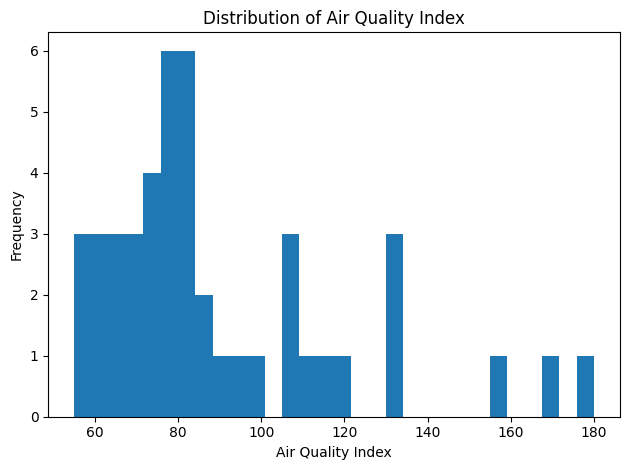

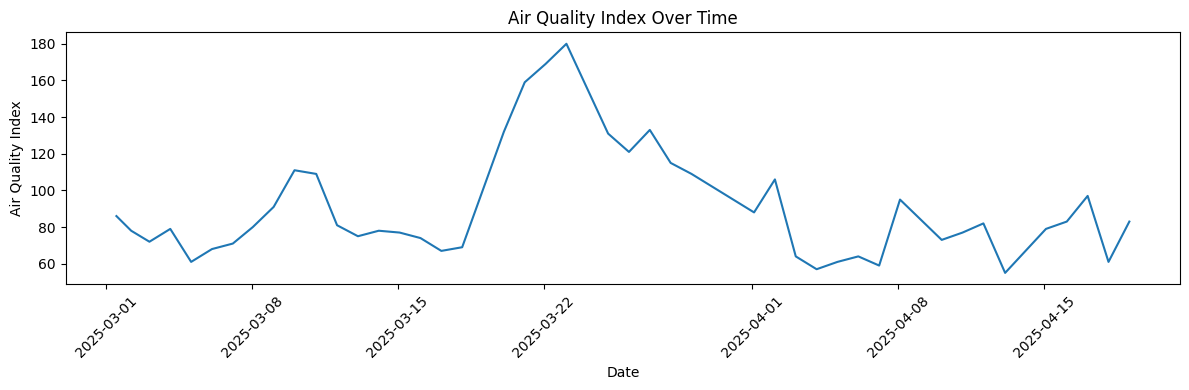

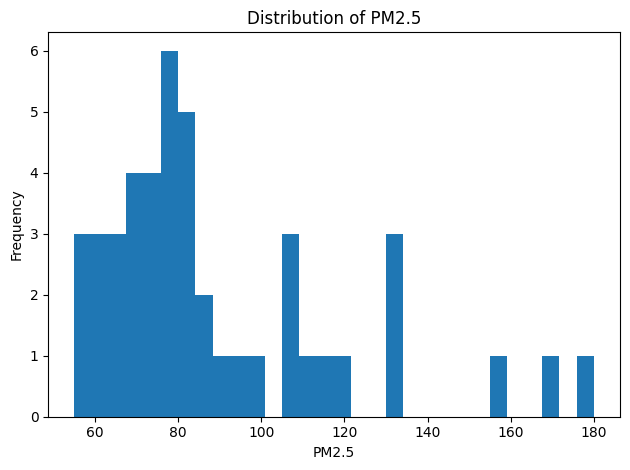

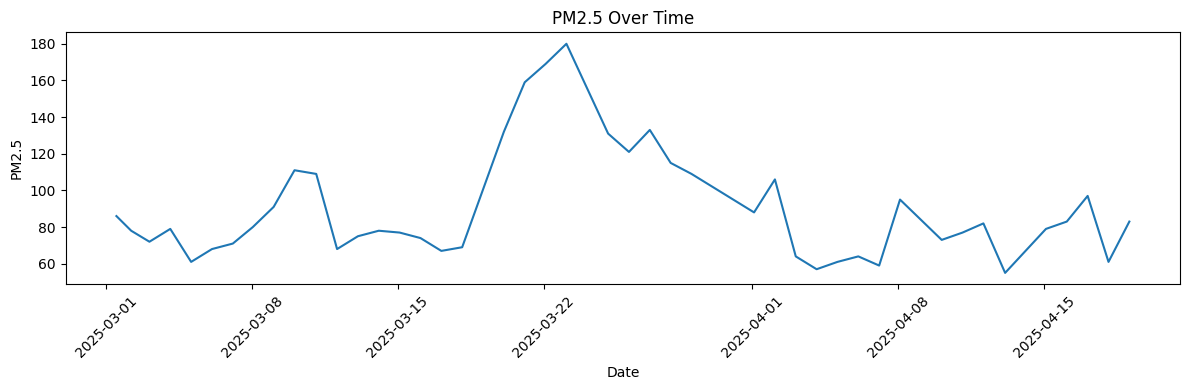

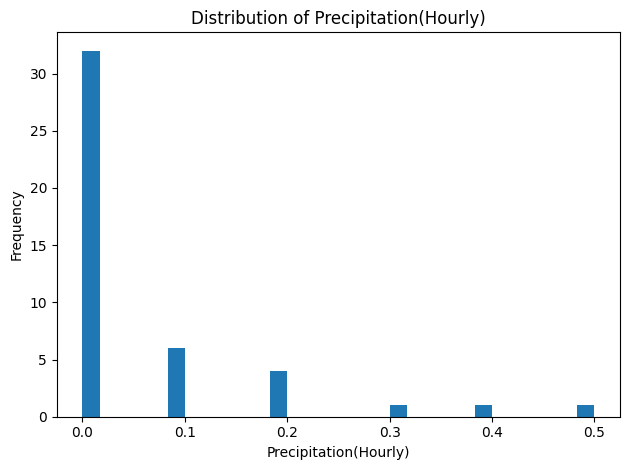

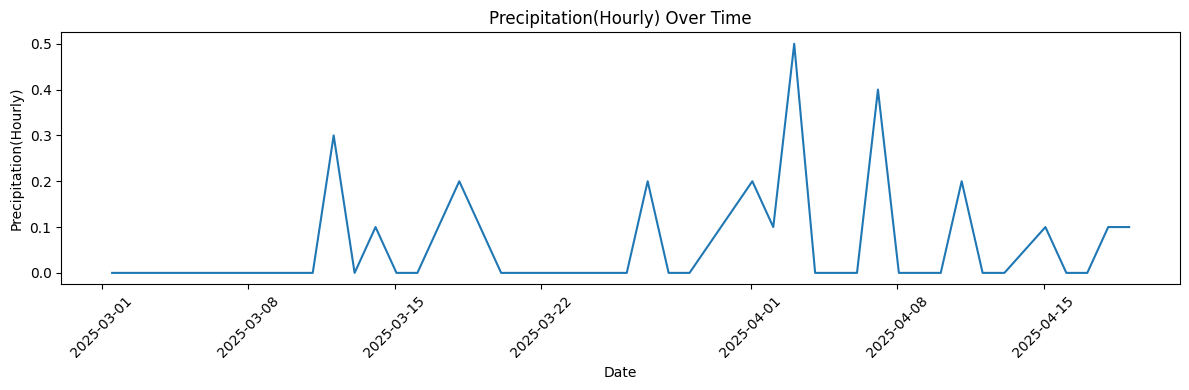

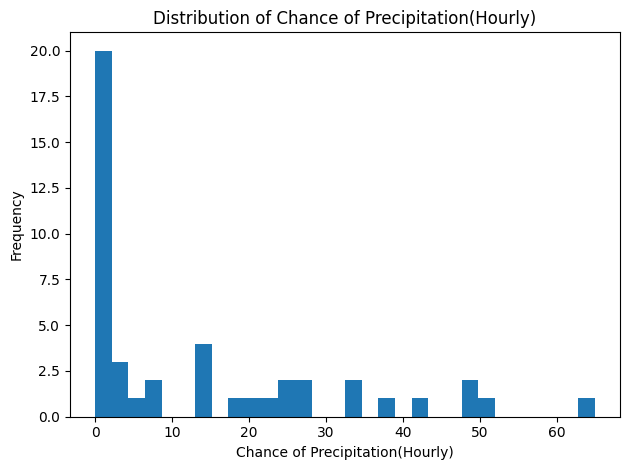

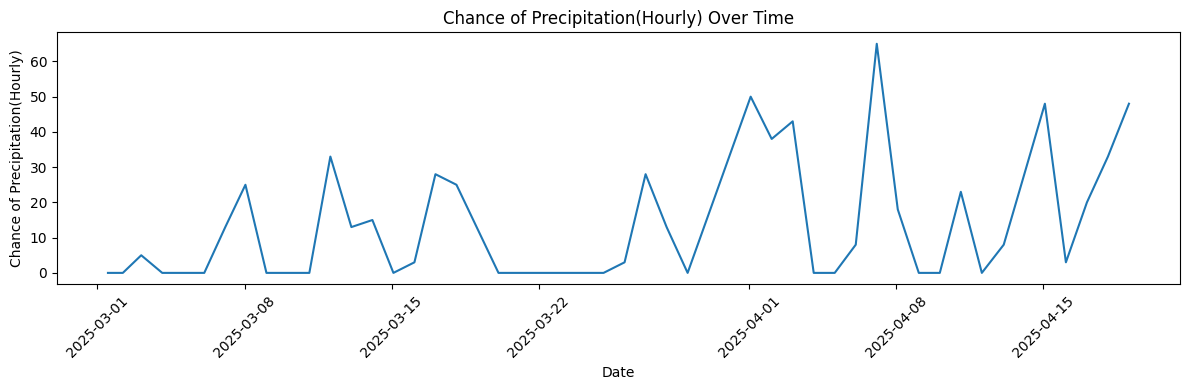

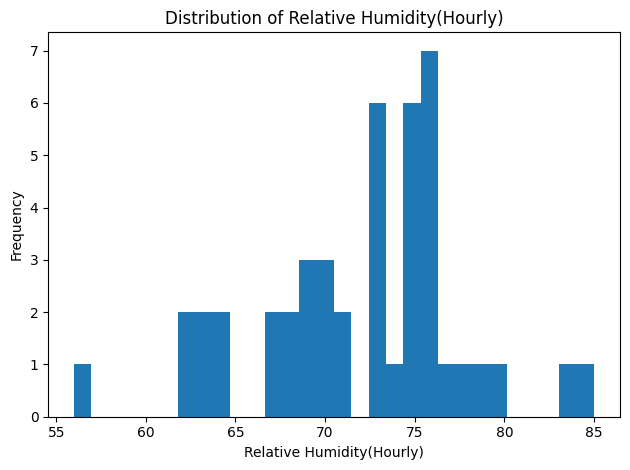

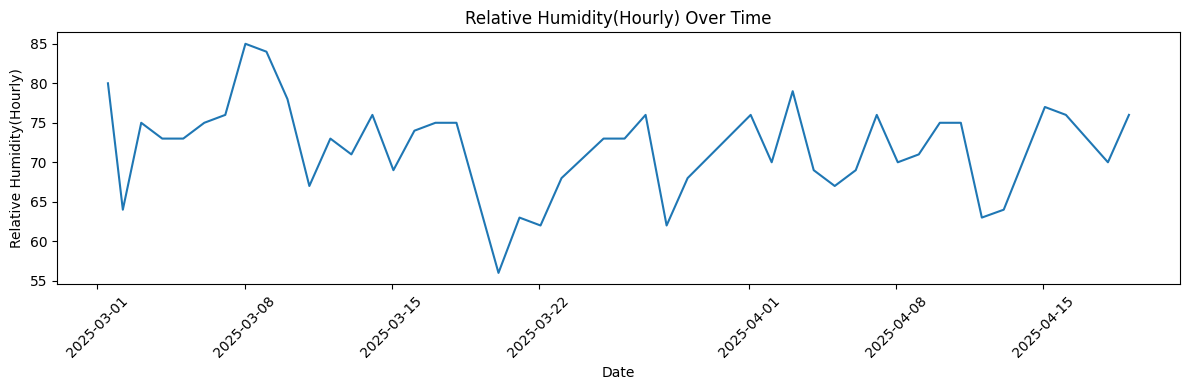

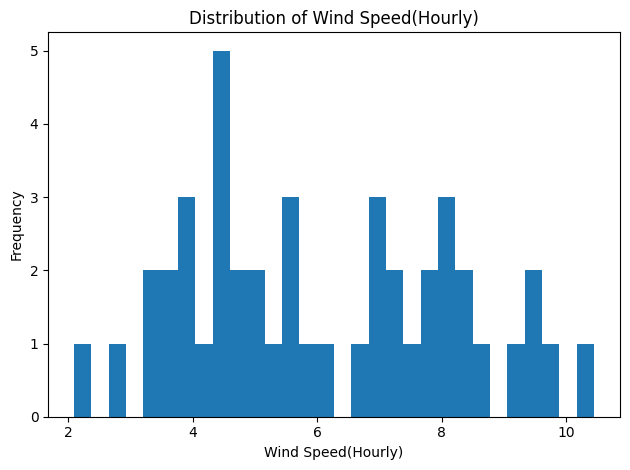

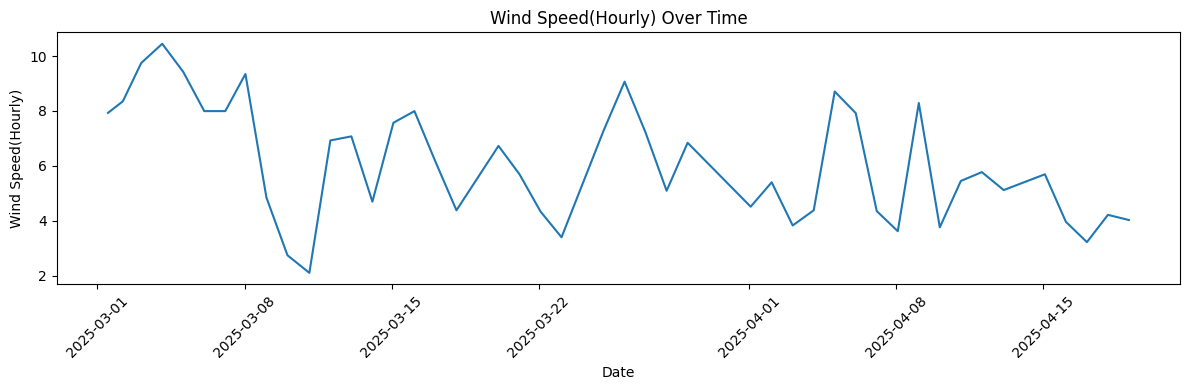

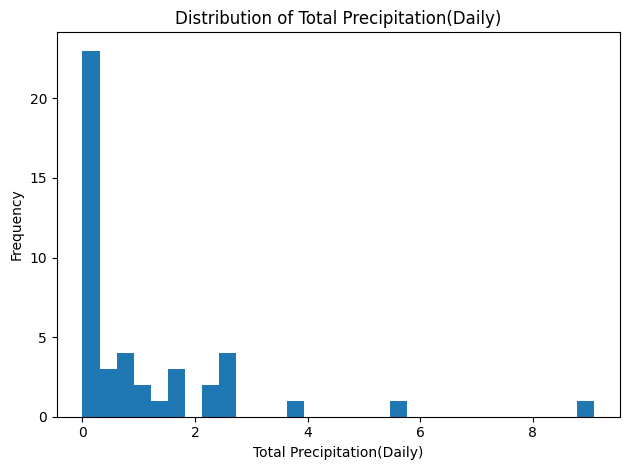

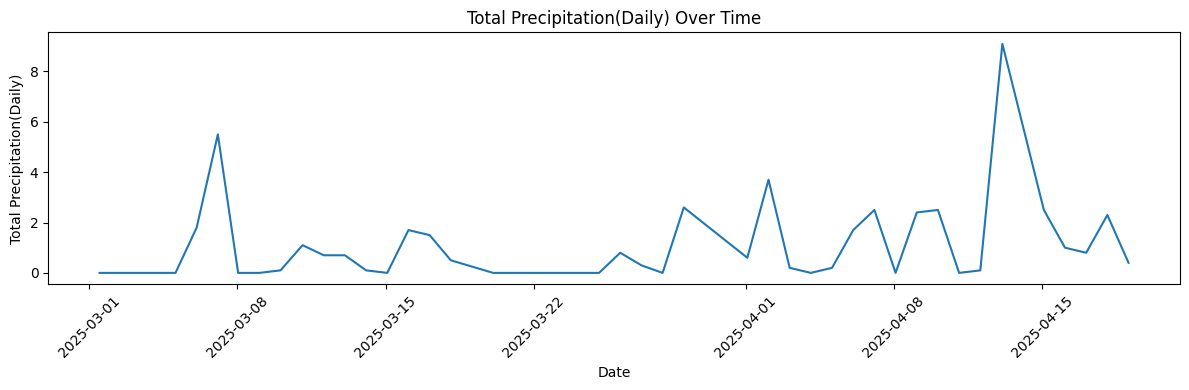

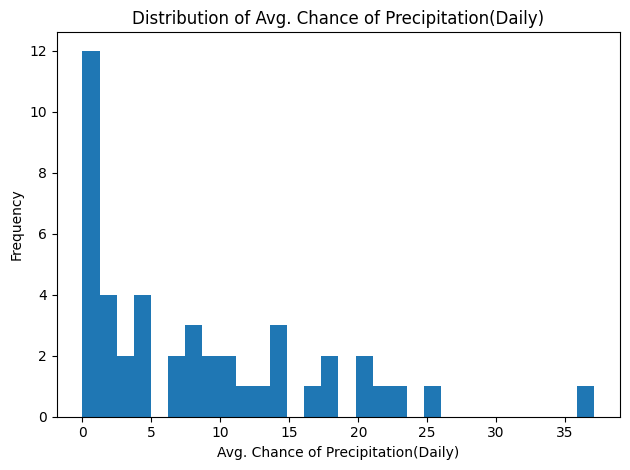

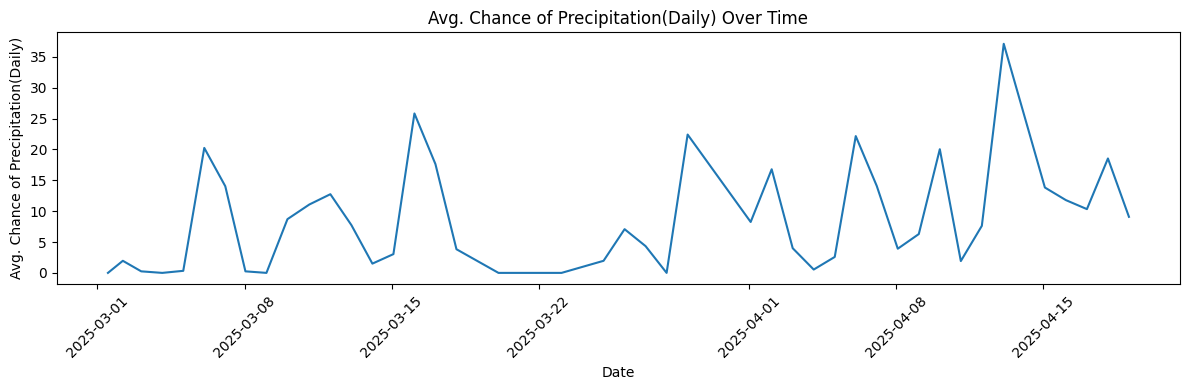

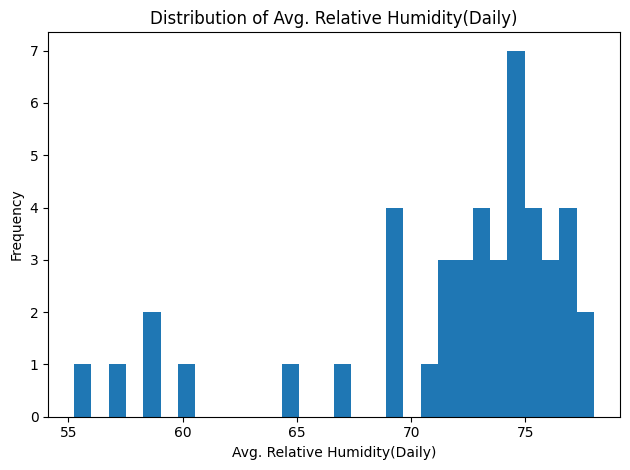

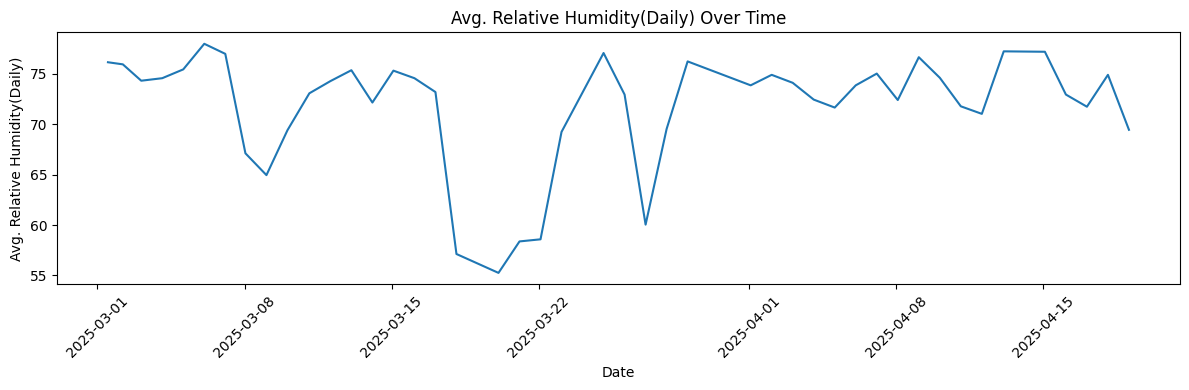

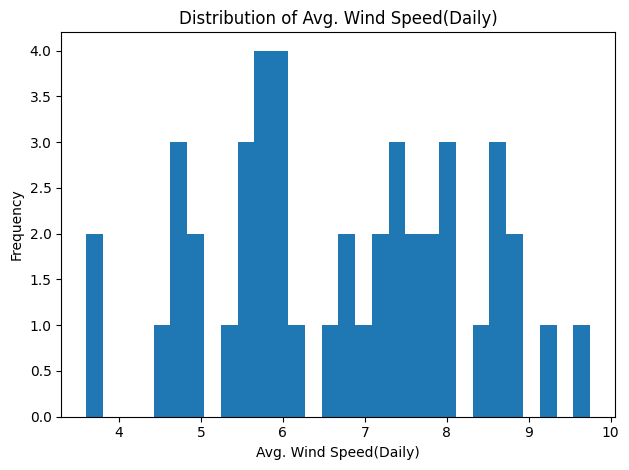

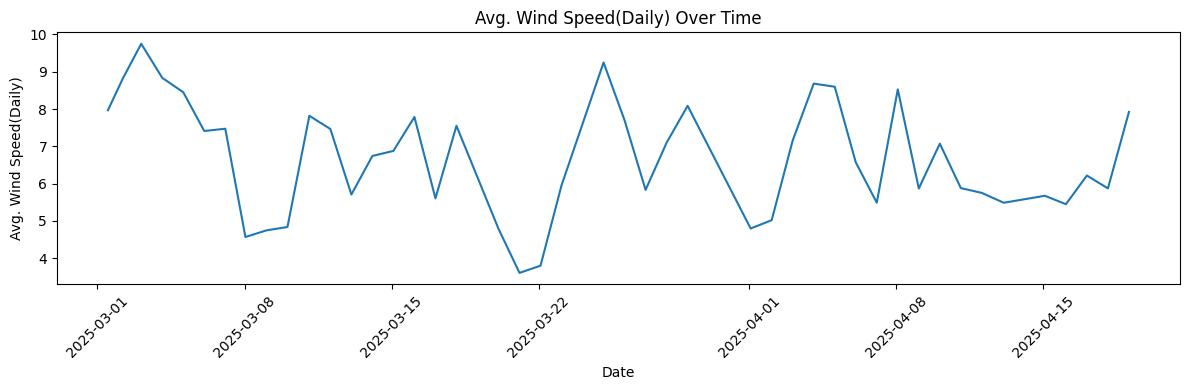

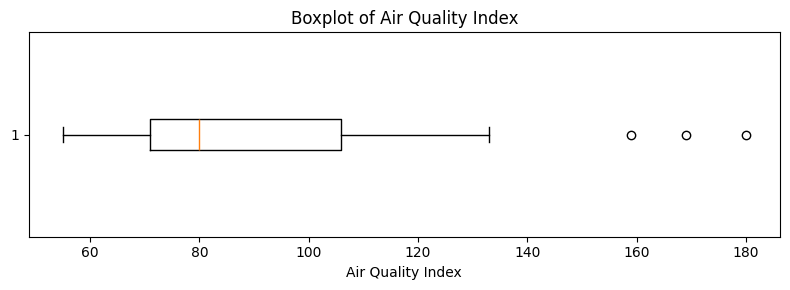

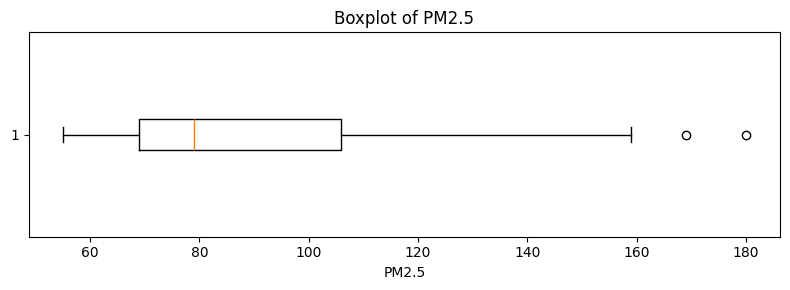

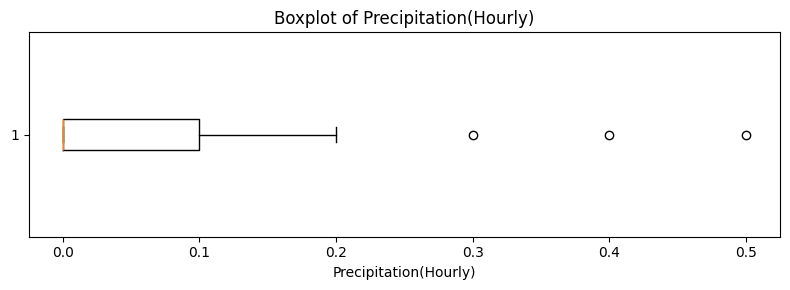

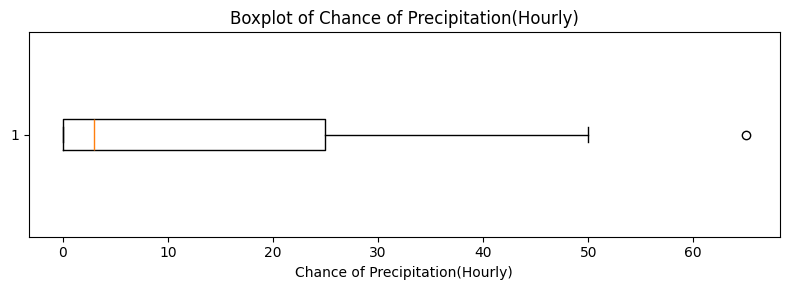

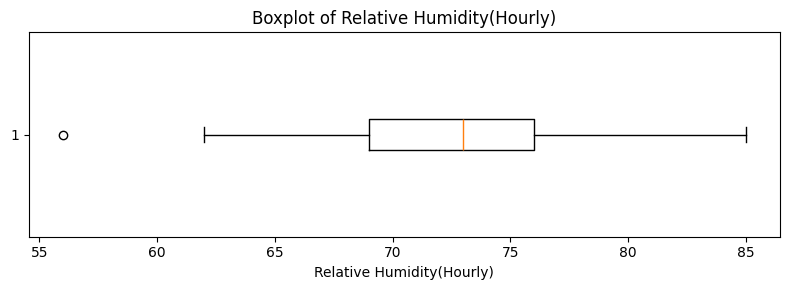

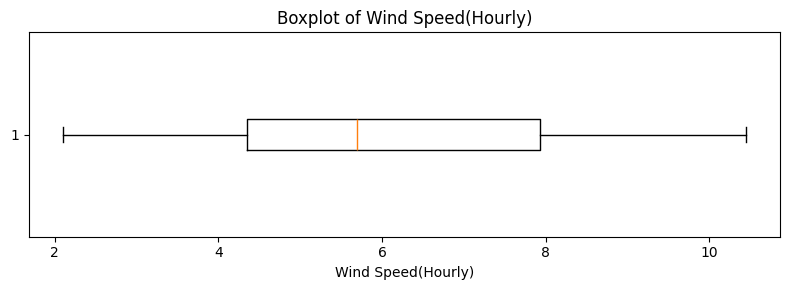

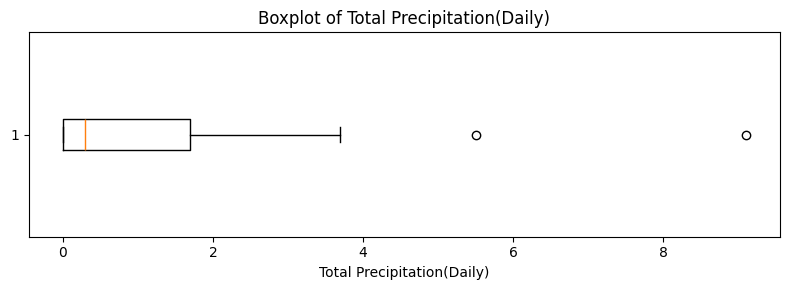

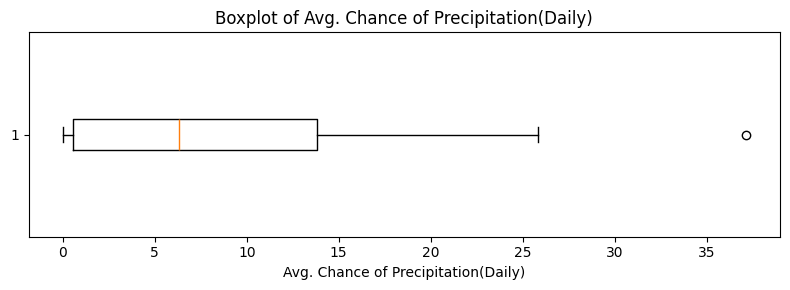

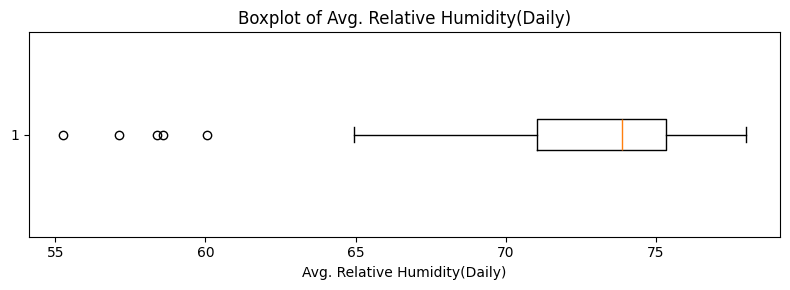

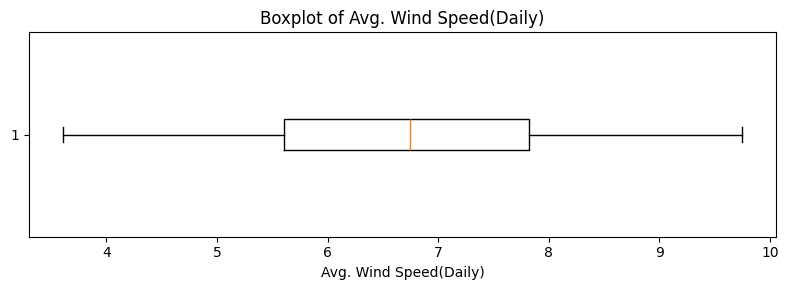

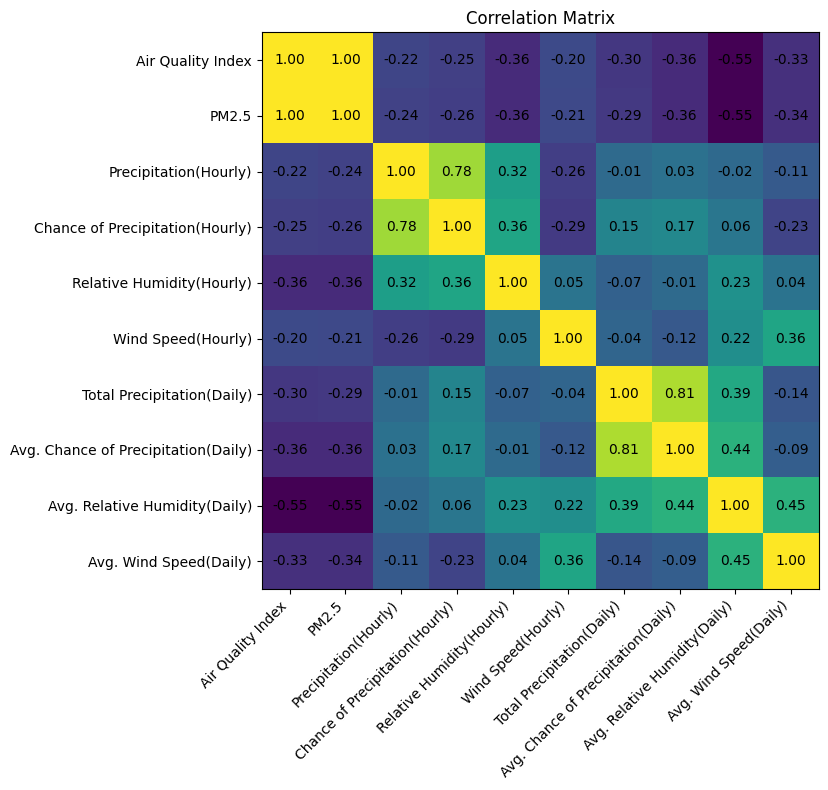

In [113]:
# 1. Histograms and Time Series in a Loop
for col in numeric_cols:
    # Histogram
    plt.figure()
    plt.hist(cleaned_df[col].dropna(), bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # Time Series
    plt.figure(figsize=(12, 4))
    plt.plot(cleaned_df['Timestamp'], cleaned_df[col])
    plt.title(f"{col} Over Time")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 2. Boxplots for Each Variable
for col in numeric_cols:
    plt.figure(figsize=(8, 3))
    plt.boxplot(cleaned_df[col].dropna(), vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# 3. Correlation Matrix
corr = cleaned_df[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr)
ax.set_xticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='right')
ax.set_yticks(range(len(numeric_cols)))
ax.set_yticklabels(numeric_cols)
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 5. Feature Engineering and Selection

For Hypothesis 1: We need Select days with low wind speed 

we know (1m/s = 3.6 km/h) and high humidity (> 70%)

According to https://www.weather.gov/pqr/wind we can consider 64 km/h is a limit for low wind

In [114]:
hypothesis_1_group1 = cleaned_df[
    (cleaned_df['Avg. Wind Speed(Daily)'] < 64) & 
    (cleaned_df['Avg. Relative Humidity(Daily)'] > 70)
]
pm25_group1 = hypothesis_1_group1['PM2.5'].dropna()
print(f"Hypothesis 1 - Filtered sample size: {len(pm25_group1)}")
print(f"Hypothesis 1 - Mean PM2.5: {pm25_group1.mean():.2f} µg/m³")


hypothesis_1_group2 = cleaned_df[
    ~((cleaned_df['Avg. Wind Speed(Daily)'] < 64) & 
    (cleaned_df['Avg. Relative Humidity(Daily)'] > 70))
]

pm25_group2 = hypothesis_1_group2['PM2.5'].dropna()
print(f"Hypothesis 1 - Filtered sample size: {len(pm25_group2)}")
print(f"Hypothesis 1 - Mean PM2.5: {pm25_group2.mean():.2f} µg/m³")

Hypothesis 1 - Filtered sample size: 34
Hypothesis 1 - Mean PM2.5: 79.68 µg/m³
Hypothesis 1 - Filtered sample size: 11
Hypothesis 1 - Mean PM2.5: 120.18 µg/m³


For Hypothesis 2: We need to Select rainy days (Total Precipitation(Daily) > 0 mm)

In [115]:
cleaned_df['Rainy Day'] = (cleaned_df['Total Precipitation(Daily)'] > 0).astype(int)

hypothesis_2_rainy = cleaned_df[cleaned_df['Rainy Day'] == 1]
hypothesis_2_non_rainy = cleaned_df[cleaned_df['Rainy Day'] == 0]
pm25_rainy = hypothesis_2_rainy['PM2.5'].dropna()
pm25_non_rainy = hypothesis_2_non_rainy['PM2.5'].dropna()
print(f"Hypothesis 2 - Rainy days sample size: {len(pm25_rainy)}")
print(f"Hypothesis 2 - Non-rainy days sample size: {len(pm25_non_rainy)}")
print(f"Hypothesis 2 - Mean PM2.5 (rainy): {pm25_rainy.mean():.2f} µg/m³")
print(f"Hypothesis 2 - Mean PM2.5 (non-rainy): {pm25_non_rainy.mean():.2f} µg/m³")


Hypothesis 2 - Rainy days sample size: 28
Hypothesis 2 - Non-rainy days sample size: 17
Hypothesis 2 - Mean PM2.5 (rainy): 81.86 µg/m³
Hypothesis 2 - Mean PM2.5 (non-rainy): 102.29 µg/m³


# 6. Hypothesis Test

### 📌 Hypothesis 1
####   H₀ (Null): There is no significant difference in PM2.5 levels on days with low wind & high humidity.
####  H₁ (Alt): PM2.5 levels are significantly higher (>100 µg/m³) when wind speed < 6.0 m/s and humidity > 70%.


H₀: μ₁ ≤ μ₂
H₁: μ₁ > μ₂
(where μ₁ is the mean PM₂.₅ on low‑wind/high‑humidity days)

In [116]:
# 1a) One‑tailed t‑test
t_stat, p_two = ttest_ind(pm25_group1, pm25_group2,
                          equal_var=False,  # Welch’s correction
                          nan_policy='omit')
# convert to one‑tailed p‑value (right‑tail)
if t_stat > 0:
    p_one = p_two / 2
else:
    p_one = 1 - (p_two / 2)

print("Hypothesis 1 — One‑tailed t‑test")
print(f"  t = {t_stat:.3f}, one‑tailed p = {p_one:.4f}")

# 1b) One‑tailed Mann–Whitney U test
u_stat, p_mw = mannwhitneyu(pm25_group1, pm25_group2,
                            alternative='greater',
                            nan_policy='omit')
print("\nHypothesis 1 — Mann–Whitney U (one‑tailed)")
print(f"  U = {u_stat:.3f}, one‑tailed p = {p_mw:.4f}")

Hypothesis 1 — One‑tailed t‑test
  t = -3.418, one‑tailed p = 0.9973

Hypothesis 1 — Mann–Whitney U (one‑tailed)
  U = 56.500, one‑tailed p = 0.9997


 t‑statistic is negative, meaning the average PM₂.₅ in group 1 is actually lower than in group 2.

 Both p‑values are effectively 1, so there is no evidence that PM₂.₅ is higher on low‑wind/high‑humidity days.

 Conclusion: PM2.5 does not appear significantly higher on those days—in fact, it’s lower on average.

 so, H0 accepted and Reject H1

### 📌 Hypothesis 2
###  H₀ (Null): There is no significant difference in PM2.5 levels on rainy days in Bangkok.
###  H₁ (Alt): There is a significant difference in PM2.5 levels on rainy days in Bangkok.

H₀: μ_rainy = μ_non‑rainy
H₁: μ_rainy ≠ μ_non‑rainy

In [117]:
# 2a) Two‑tailed Welch’s t‑test
t2, p2 = ttest_ind(pm25_rainy, pm25_non_rainy,
                   equal_var=False,
                   nan_policy='omit')
print("Hypothesis 2 — Welch’s two‑tailed t‑test")
print(f"  t = {t2:.3f}, two‑tailed p = {p2:.4f}")

# 2b) Two‑tailed Mann–Whitney U test
u2, p_mw2 = mannwhitneyu(pm25_rainy, pm25_non_rainy,
                        alternative='two-sided',
                        nan_policy='omit')
print("\nHypothesis 2 — Mann–Whitney U (two‑tailed)")
print(f"  U = {u2:.3f}, two‑tailed p = {p_mw2:.4f}")


Hypothesis 2 — Welch’s two‑tailed t‑test
  t = -2.028, two‑tailed p = 0.0551

Hypothesis 2 — Mann–Whitney U (two‑tailed)
  U = 161.000, two‑tailed p = 0.0732


Both tests give p‑values slightly above 0.05.

There’s a hint of lower PM₂.₅ on rainy days (t is negative), but it’s not quite statistically significant at the 5% level.

Conclusion: we do not have strong evidence of a difference in PM₂.₅ between rainy and non‑rainy days (at α = 0.05).

 so, H0 accepted and Reject H1

# 7. Machine Learning / Data Modeling

For Hypothesis 1, trying to predict PM2.5 from Avg. Wind Speed(Daily) & Avg. Relative Humidity(Daily)

=== Hypothesis 1: Full‑data fit ===
 Coefs (wind, humidity): [-2.2017894 -2.6012228]
 Intercept:             291.0802
 R²:                    0.310289204120636
 MSE:                   600.768310546875

=== Hypothesis 1: 5‑Fold CV ===
 R² scores: [-0.15133476  0.23272741 -0.38998592  0.14419901 -0.01263893]
 Mean CV R²: -0.035406637191772464
 Overall CV MSE: 704.4730224609375


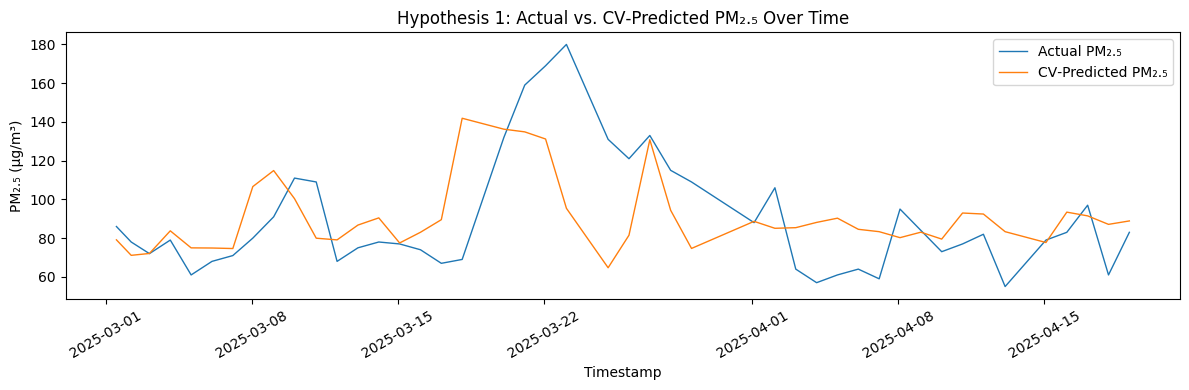

In [118]:
# Select Features
hypothesis_1_model_1 = cleaned_df.dropna(subset=[
    'Timestamp',
    'PM2.5',
    'Avg. Wind Speed(Daily)',
    'Avg. Relative Humidity(Daily)'
]).copy()

# Features & target
X1 = hypothesis_1_model_1[['Avg. Wind Speed(Daily)', 'Avg. Relative Humidity(Daily)']].values
y1 = hypothesis_1_model_1['PM2.5'].values

# Fit the model
lr1 = LinearRegression()
lr1.fit(X1, y1)
hypothesis_1_model_1['PM25_pred_full'] = lr1.predict(X1)

print("=== Hypothesis 1: Full‑data fit ===")
print(" Coefs (wind, humidity):", lr1.coef_)
print(" Intercept:            ", lr1.intercept_)
print(" R²:                   ", r2_score(y1, hypothesis_1_model_1['PM25_pred_full']))
print(" MSE:                  ", mean_squared_error(y1, hypothesis_1_model_1['PM25_pred_full']))

# 5‑fold cross‑validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
hypothesis_1_model_1['PM25_pred_cv'] = cross_val_predict(lr1, X1, y1, cv=kf)

r2_scores1 = cross_val_score(lr1, X1, y1, cv=kf, scoring='r2')
print("\n=== Hypothesis 1: 5‑Fold CV ===")
print(" R² scores:", r2_scores1)
print(" Mean CV R²:", r2_scores1.mean())
print(" Overall CV MSE:", mean_squared_error(y1, hypothesis_1_model_1['PM25_pred_cv']))

# Time‑series plot (Actual vs. CV‑Predicted)
hypothesis_1_model_1 = hypothesis_1_model_1.set_index('Timestamp')
plt.figure(figsize=(12,4))
plt.plot(hypothesis_1_model_1.index, hypothesis_1_model_1['PM2.5'],
         label='Actual PM₂.₅', linewidth=1)
plt.plot(hypothesis_1_model_1.index, hypothesis_1_model_1['PM25_pred_cv'],
         label='CV‑Predicted PM₂.₅', linewidth=1)
plt.title('Hypothesis 1: Actual vs. CV‑Predicted PM₂.₅ Over Time')
plt.xlabel('Timestamp')
plt.ylabel('PM₂.₅ (µg/m³)')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

For Hypothesis 2, we are going to predict PM2.5 based on rainy days


=== Hypothesis 2: Full‑data fit ===
 Coef (Rainy): -20.436974789915965
 Intercept:    102.29411764705883
 R²:           0.1127132765090183
 MSE:          772.8657329598504

=== Hypothesis 2: 5‑Fold CV ===
 R² scores: [-0.19362843  0.13627843 -1.6945247   0.12286098 -0.27906509]
 Mean CV R²: -0.38161576132885633
 Overall CV MSE: 846.2600887892411


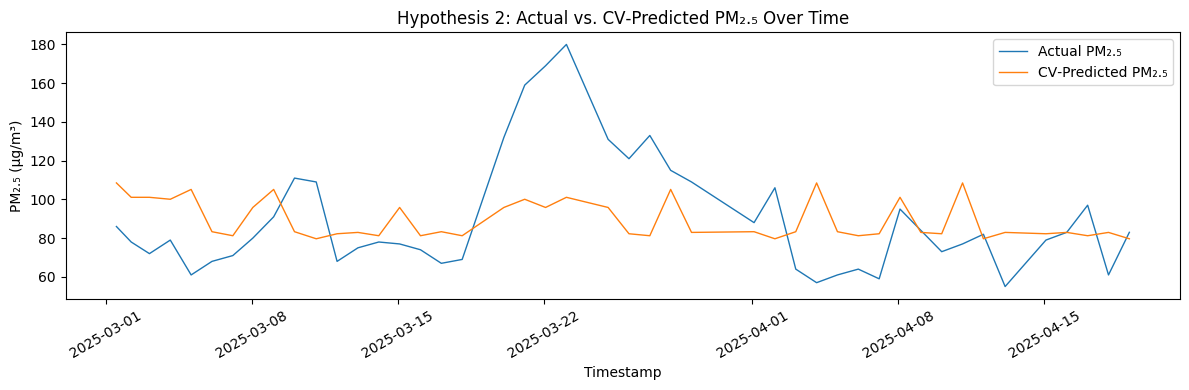

In [119]:
# Select Features
hypothesis_2_model_2 = cleaned_df.dropna(subset=[
    'Timestamp',
    'PM2.5',
    'Total Precipitation(Daily)'
]).copy()
hypothesis_2_model_2['Rainy'] = (
    hypothesis_2_model_2['Total Precipitation(Daily)'] > 0
).astype(int)

# Features & target
X2 = hypothesis_2_model_2[['Rainy']].values
y2 = hypothesis_2_model_2['PM2.5'].values

# Fit on full data
lr2 = LinearRegression()
lr2.fit(X2, y2)
hypothesis_2_model_2['PM25_pred_full'] = lr2.predict(X2)

print("\n=== Hypothesis 2: Full‑data fit ===")
print(" Coef (Rainy):", lr2.coef_[0])
print(" Intercept:   ", lr2.intercept_)
print(" R²:          ", r2_score(y2, hypothesis_2_model_2['PM25_pred_full']))
print(" MSE:         ", mean_squared_error(y2, hypothesis_2_model_2['PM25_pred_full']))

# 5‑fold cross‑validation
hypothesis_2_model_2['PM25_pred_cv'] = cross_val_predict(lr2, X2, y2, cv=kf)

r2_scores2 = cross_val_score(lr2, X2, y2, cv=kf, scoring='r2')
print("\n=== Hypothesis 2: 5‑Fold CV ===")
print(" R² scores:", r2_scores2)
print(" Mean CV R²:", r2_scores2.mean())
print(" Overall CV MSE:", mean_squared_error(y2, hypothesis_2_model_2['PM25_pred_cv']))

# Time‑series plot (Actual vs. CV‑Predicted)
hypothesis_2_model_2 = hypothesis_2_model_2.set_index('Timestamp')
plt.figure(figsize=(12,4))
plt.plot(hypothesis_2_model_2.index, hypothesis_2_model_2['PM2.5'],
         label='Actual PM₂.₅', linewidth=1)
plt.plot(hypothesis_2_model_2.index, hypothesis_2_model_2['PM25_pred_cv'],
         label='CV‑Predicted PM₂.₅', linewidth=1)
plt.title('Hypothesis 2: Actual vs. CV‑Predicted PM₂.₅ Over Time')
plt.xlabel('Timestamp')
plt.ylabel('PM₂.₅ (µg/m³)')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()